# TK Analysis
`TK Comparação.xlsx` -> `data.xlsx` file, cells B1 to G73 processed.

In [2]:
# Import Required Libraries

import pandas as pd, numpy as np, statsmodels.api as sm, warnings

from scipy.special import logit
from scipy.stats import pearsonr
from sklearn.metrics import (
    precision_recall_fscore_support,
    average_precision_score,
    confusion_matrix
)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from plotnine import (
    ggplot, aes, labs,
    geom_tile, 
    geom_text, 
    geom_line, 
    geom_point,
    geom_vline, geom_boxplot, geom_histogram, geom_ribbon,
    scale_fill_gradient, scale_color_manual,
    scale_x_discrete, scale_x_continuous, scale_x_datetime,
    scale_y_discrete, scale_y_continuous,
    theme, theme_minimal, element_text, facet_wrap,
)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
# Load the Excel file
data = pd.read_excel('data.xlsx', usecols='B:G', nrows=73)

# Add AML column
data['AML'] = data['Código'].apply(
    lambda x: 'T' if x in ['IDP413', 'IDP421', 'IDP468', 'IDP527', 'IDP530'] else 
              ('TB' if x in ['IDP450', 'IDP499'] else None)
)
# Convert RNAse column to float64
data['RNAse'] = pd.to_numeric(data['RNAse'], errors='coerce')

print(data)

                  Código       Data     Placa    TREC     KREC     RNAse   AML
0                 IDP406 2022-09-23   Placa 1  21.051  494.942  2854.244  None
1                 IDP407 2022-09-23   Placa 1  46.005  459.626  3505.153  None
2                 IDP410 2022-09-23   Placa 1  24.408  246.587  1708.116  None
3                 IDP412 2022-09-23   Placa 1  38.012  369.542  1755.735  None
4                 IDP413 2022-09-23   Placa 1   1.374   91.927  3040.899     T
..                   ...        ...       ...     ...      ...       ...   ...
67                IDP538 2024-07-25  Placa 14  67.305  501.038  2253.805  None
68                IDP539 2024-07-25  Placa 14  28.479  434.421  1787.374  None
69                IDP546 2025-07-10  Placa 17  49.309   84.228   603.738  None
70                IDP555 2025-07-10  Placa 17   0.562    8.179   861.445  None
71  R.S (Paciente Laire) 2024-02-01  Placa 12  70.345   58.412  1033.822  None

[72 rows x 7 columns]


## Descriptive analysis

Checking if `Código`s are unique.

In [4]:
unique_codigo = data['Código'].nunique()
placa_counts = data.groupby('Código')['Placa'].nunique()
print(f"Unique Código: {unique_codigo}\n")
print(f"Placa counts per Código:\n\n{placa_counts}")

Unique Código: 72

Placa counts per Código:

Código
IDP406                  1
IDP407                  1
IDP410                  1
IDP412                  1
IDP413                  1
                       ..
IDP538                  1
IDP539                  1
IDP546                  1
IDP555                  1
R.S (Paciente Laire)    1
Name: Placa, Length: 72, dtype: int64


Correlation matrix with p-values (statistical significance) - Pearson type which captures linear correlations.

In [5]:
columns_to_analyze = ['TREC', 'KREC', 'RNAse']

correlation_matrix = data[columns_to_analyze].corr()
print(f"""
Correlation Matrix:

{correlation_matrix}
""")

p_values = np.zeros((len(columns_to_analyze), len(columns_to_analyze)))

for i, col1 in enumerate(columns_to_analyze):
    for j, col2 in enumerate(columns_to_analyze):
        if i != j:
            _, p_value = pearsonr(data[col1].dropna(), data[col2].dropna())
            p_values[i, j] = p_value
        else:
            p_values[i, j] = np.nan
print(f"""
P-Values Matrix:
      
{p_values}
""")


Correlation Matrix:

           TREC      KREC     RNAse
TREC   1.000000  0.046622  0.080517
KREC   0.046622  1.000000  0.474950
RNAse  0.080517  0.474950  1.000000


P-Values Matrix:

[[           nan 6.97360521e-01 5.01365246e-01]
 [6.97360521e-01            nan 2.49285818e-05]
 [5.01365246e-01 2.49285818e-05            nan]]



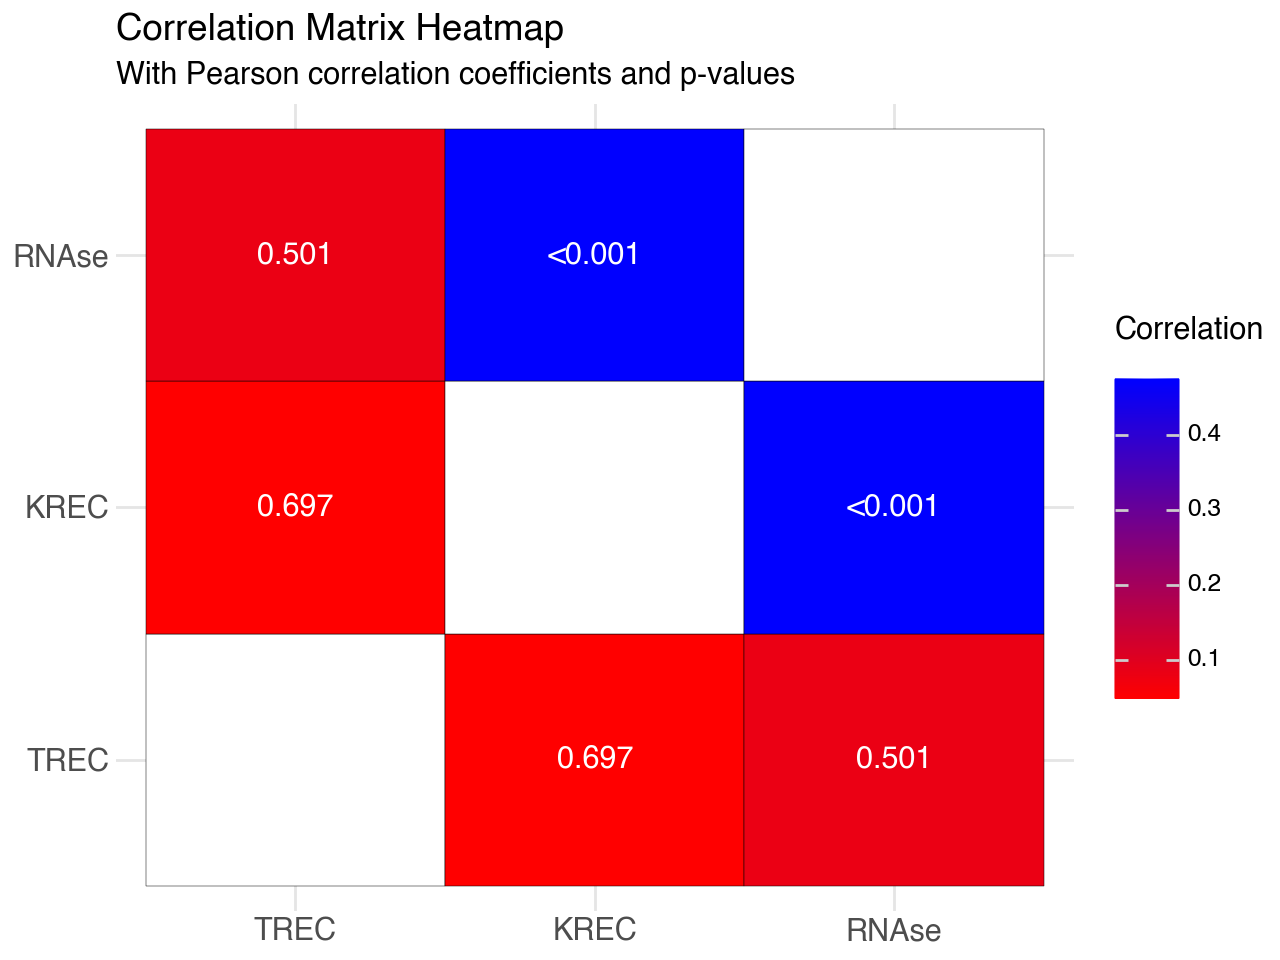

In [6]:
correlation_matrix.values[np.diag_indices_from(correlation_matrix)] = np.nan

corr_df = correlation_matrix.reset_index().melt(id_vars='index')
corr_df.columns = ['y', 'x', 'value']

# Prepare p-value DataFrame
pval_df = pd.DataFrame(
    p_values, columns=correlation_matrix.columns, index=correlation_matrix.index
)
pval_df = pval_df.reset_index().melt(id_vars='index')
pval_df.columns = ['y', 'x', 'pval']

# Merge for annotation
corr_df = corr_df.merge(pval_df, on=['x', 'y'])

# Formatted label column for p-values
corr_df['pval_label'] = corr_df['pval'].apply(
    lambda v: "<0.001" if pd.notnull(v) and v < 0.001 else (f"{v:.3f}" if pd.notnull(v) else "")
)
col_order = list(correlation_matrix.columns)
(
    ggplot(corr_df) +
    aes(x='x', y='y', fill='value') +
    geom_tile(color='black') +
    scale_x_discrete(limits=col_order) +
    scale_y_discrete(limits=col_order) +
    geom_text(aes(label='pval_label'), size=11, color='white') +
    scale_fill_gradient(low='red', high='blue', na_value='white') +
    labs(
        title="Correlation Matrix Heatmap", 
        subtitle="With Pearson correlation coefficients and p-values",
        x="", y="", fill="Correlation\n"
    ) +
    theme_minimal() +
    theme(
        axis_text_x=element_text(size = 11),
        axis_text_y=element_text(size = 11)
    )
)

In [7]:
summary = data[columns_to_analyze].describe()
print(f"""
Descriptive Statistics:
      
{summary}
""")


Descriptive Statistics:

             TREC        KREC        RNAse
count   72.000000   72.000000    72.000000
mean    46.600403  189.600556  1864.727931
std     90.382545  151.811625  1150.747681
min      0.105000    0.553000   179.528000
25%     12.124250   58.682750  1089.889750
50%     27.158500  147.874500  1564.314000
75%     50.184250  310.190500  2463.193500
max    731.635000  585.944000  6279.900000



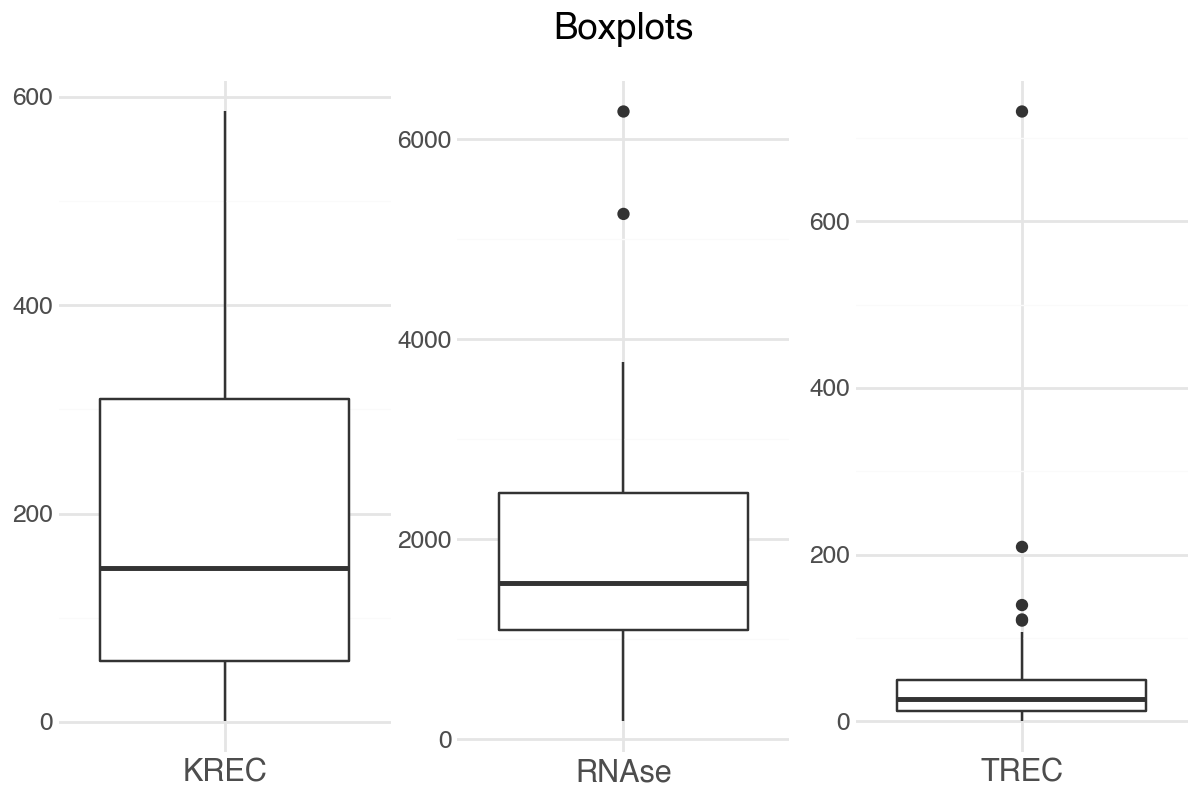

In [8]:
data_melted = data.melt(
    value_vars=columns_to_analyze, var_name='Column', value_name='Value', 
    id_vars=['Código', 'Placa', 'Data', 'AML']
)
(
    ggplot(data_melted) +
    aes(x='Column', y='Value') +
    geom_boxplot() +
    facet_wrap('~Column', scales='free') +
    labs(title="Boxplots", x="", y="") +
    theme_minimal() +
    theme(
        strip_text_x=element_text(alpha=0), 
        axis_text_x=element_text(size=11), figure_size=(6, 4)
    )
)

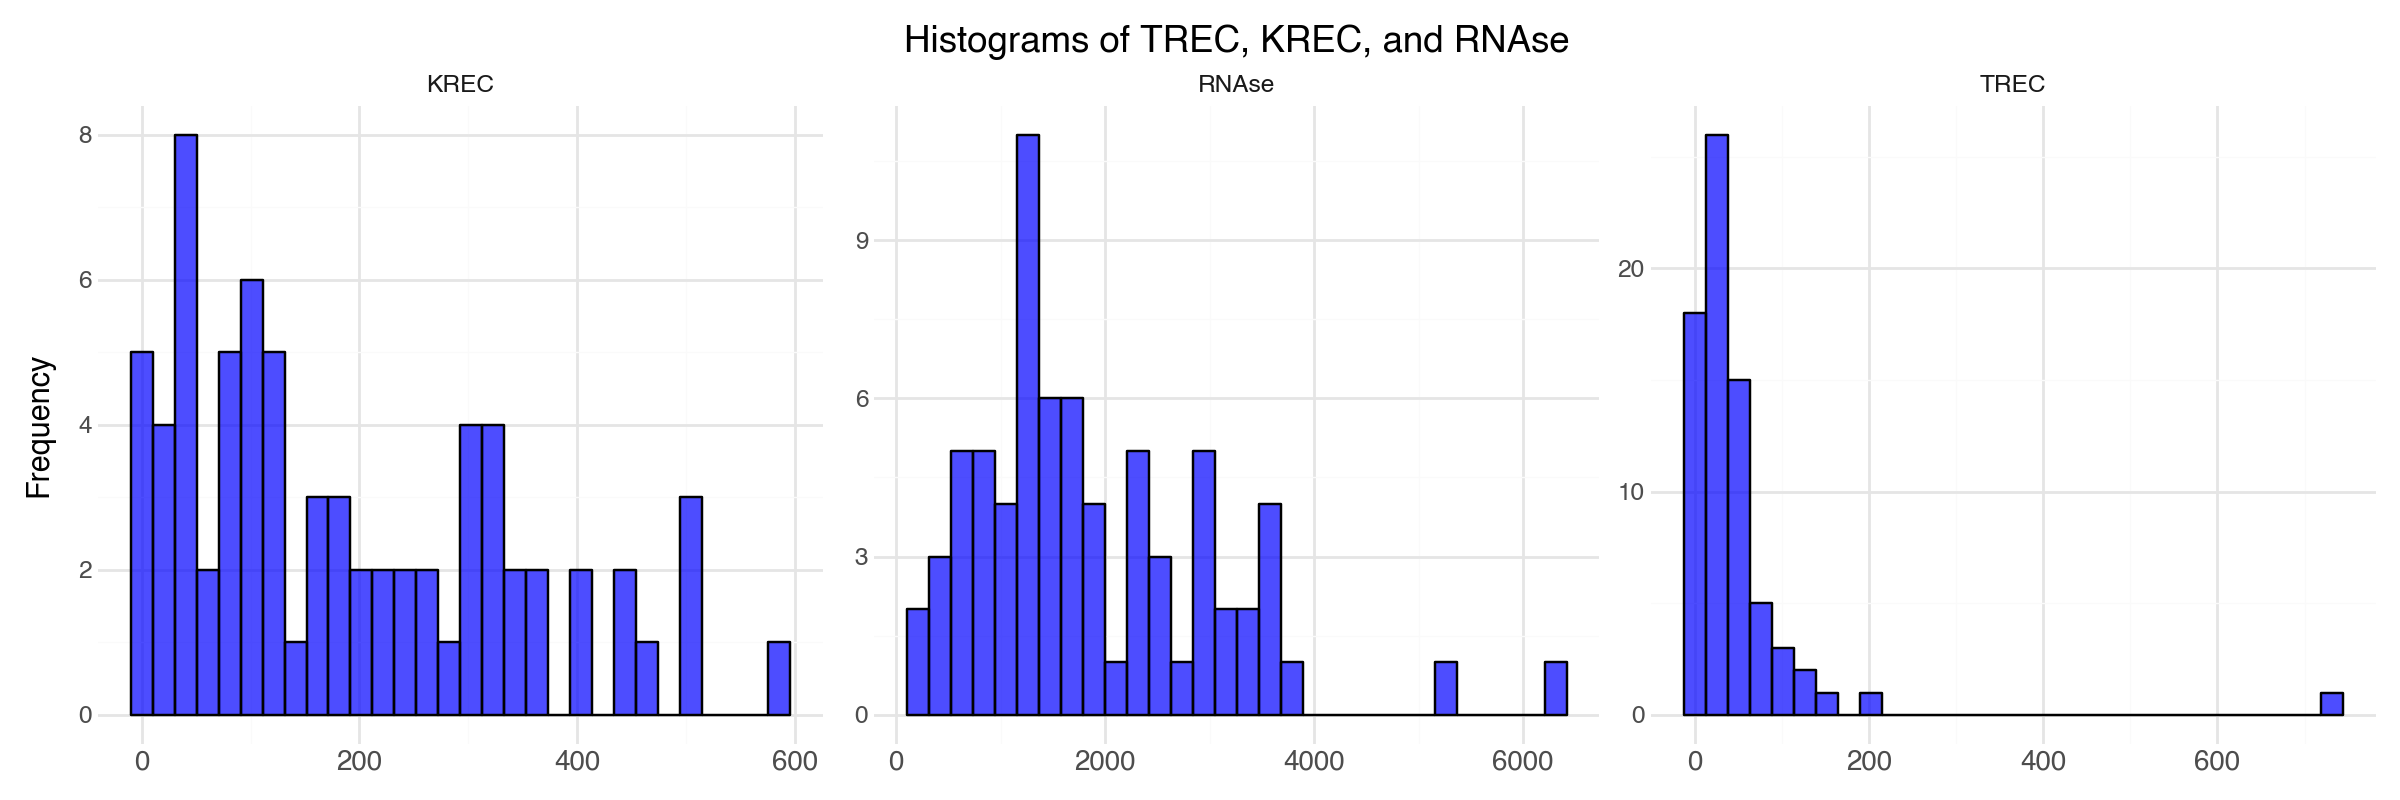

In [9]:
(
    ggplot(data_melted, aes(x='Value')) +
    geom_histogram(bins=30, fill="blue", alpha=0.7, color="black") +
    facet_wrap('~Column', scales='free') +
    labs(title="Histograms of TREC, KREC, and RNAse", x="", y="Frequency") +
    theme_minimal() +
    theme(figure_size=(12, 4), axis_text_x=element_text(size=10))
)

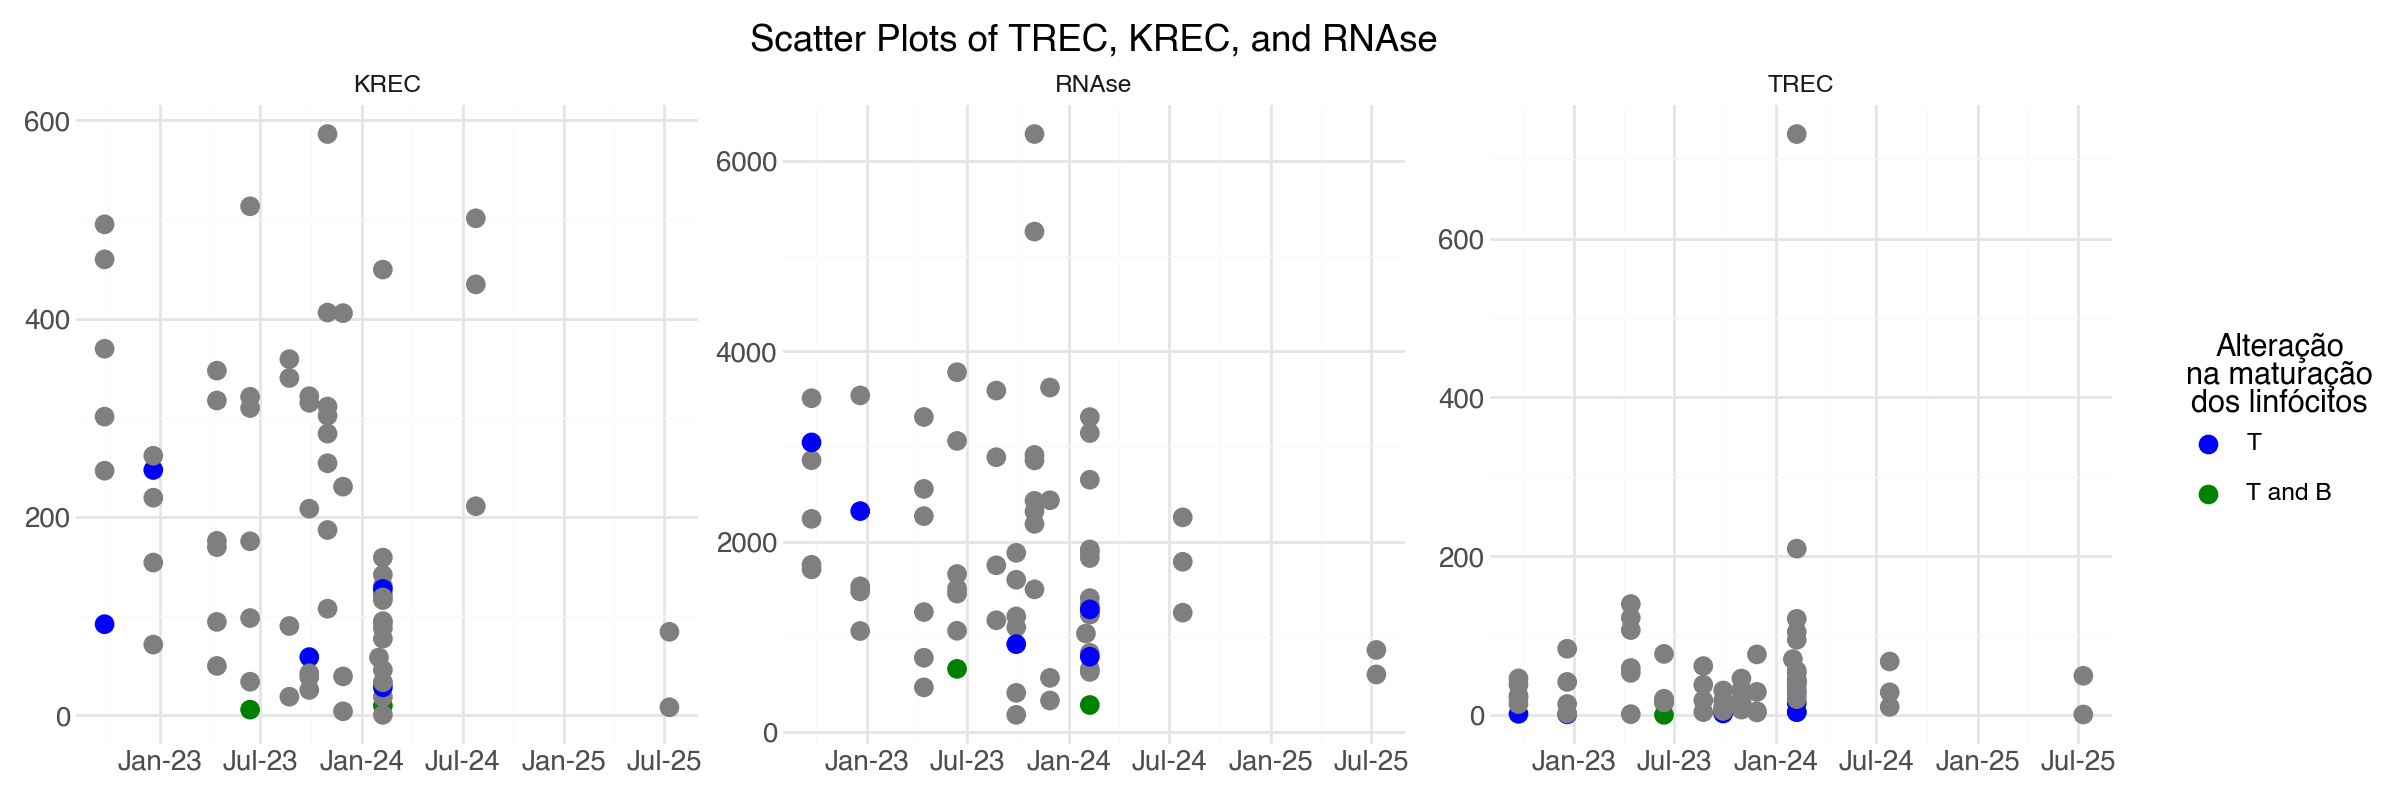

In [10]:
# Scatter-plots side by side
(
    ggplot(data_melted, aes(x='Data', y='Value', color='AML')) +
    geom_point(size=3) +
    facet_wrap('~Column', scales='free') +
    labs(
        title="Scatter Plots of TREC, KREC, and RNAse", 
        x="", y="", color="Alteração\nna maturação\ndos linfócitos"
    ) +
    scale_x_datetime(date_breaks='6 months', date_labels='%b-%y') +
    scale_color_manual(
        values=["blue", "green", "gray"],
        breaks=["T", "TB"],  # Only include "T" and "TB" in the legend
        labels=["T", "T and B"]
    ) +
    theme_minimal() +
    theme(figure_size=(12, 4), axis_text=element_text(size=10))
)

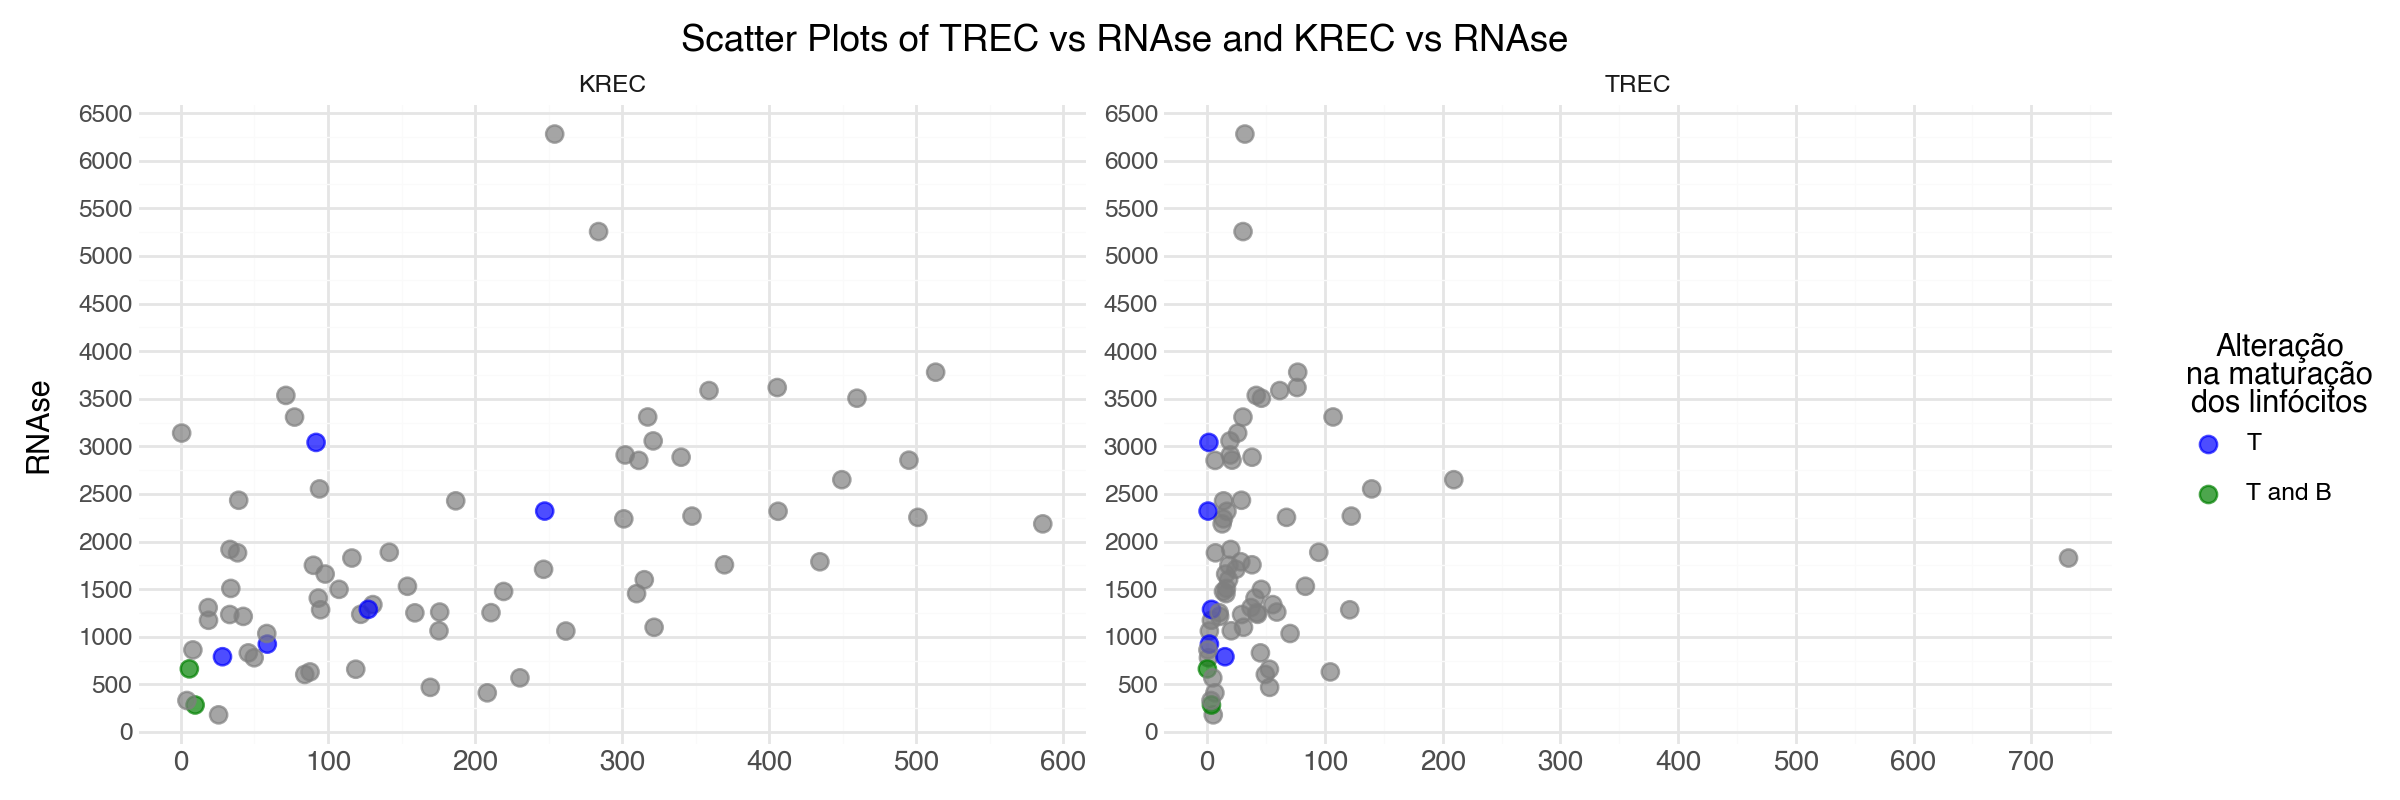

In [11]:
# Prepare the data for scatter plots
scatter_data = data.melt(
    id_vars=['Código', 'Placa', 'Data', 'AML', 'RNAse'],
    value_vars=['TREC', 'KREC'],
    var_name='Variable',
    value_name='Value'
)
(
    ggplot(scatter_data, aes(x='Value', y='RNAse', color='AML')) +
    geom_point(size=3, alpha=0.7) +
    facet_wrap('~Variable', scales='free') +
    labs(
        title="Scatter Plots of TREC vs RNAse and KREC vs RNAse",
        x="",
        y="RNAse",
        color="Alteração\nna maturação\ndos linfócitos"
    ) +
    scale_x_continuous(breaks=list(range(0, 800, 100))) +
    scale_y_continuous(breaks=list(range(0, 7000, 500))) +
    scale_color_manual(
        values=["blue", "green", "gray"],
        breaks=["T", "TB"],  # Only include "T" and "TB" in the legend
        labels=["T", "T and B"]
    ) +
    theme_minimal() +
    theme(figure_size=(12, 4), axis_text_x=element_text(size=10))
)

In the log scale for better visualization.

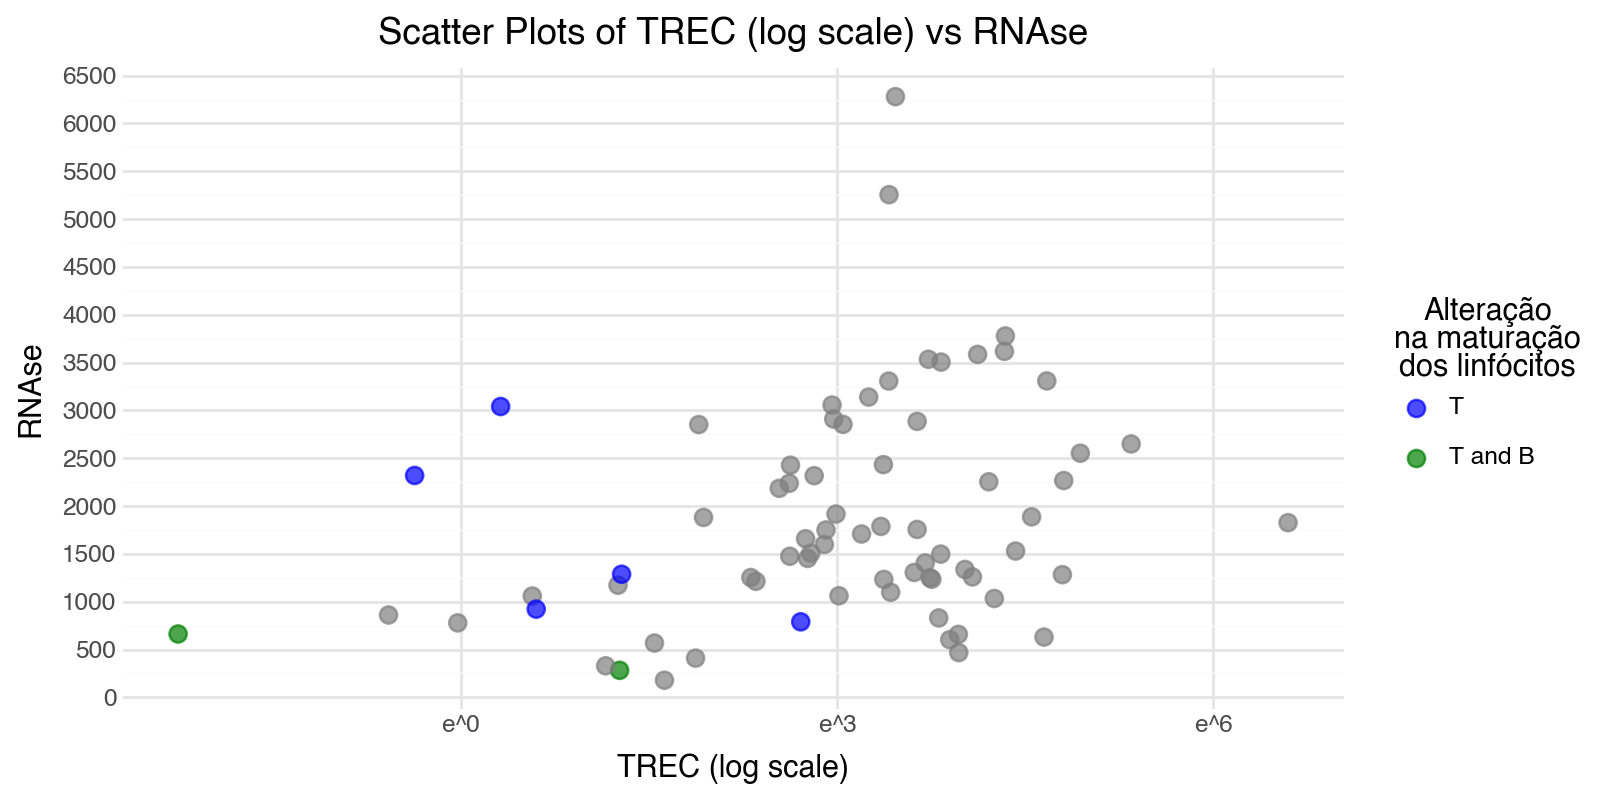

In [12]:
(
    ggplot(data, aes(x='TREC', y='RNAse', color='AML')) +
    geom_point(size=3, alpha=0.7) +
    labs(
        title="Scatter Plots of TREC (log scale) vs RNAse",
        x="TREC (log scale)",
        y="RNAse",
        color="Alteração\nna maturação\ndos linfócitos"
    ) +
    scale_x_continuous(trans='log') +
    scale_y_continuous(breaks=list(range(0, 7000, 500))) +
    scale_color_manual(
        values=["blue", "green", "gray"],
        breaks=["T", "TB"],  # Only include "T" and "TB" in the legend
        labels=["T", "T and B"]
    ) +
    theme_minimal() +
    theme(figure_size=(8, 4))
)

## Defining cutoff values

In [13]:
data['LT'] = data['AML'].apply(lambda x: 1 if x in ['T', 'TB'] else 0)
data['LB'] = data['AML'].apply(lambda x: 1 if x == 'TB' else 0)

print(f"""
T-cell lymphopenia:

{data.groupby('LT').size()}
""")
print(f"""
B-cell lymphopenia:

{data.groupby('LB').size()}
""")


T-cell lymphopenia:

LT
0    65
1     7
dtype: int64


B-cell lymphopenia:

LB
0    70
1     2
dtype: int64



### T- and B- cell lymphopenias

In [14]:
# ============================================================
#  CUT-OFF ANALYSIS USING L2-PENALIZED (RIDGE) LOGISTIC REGRESSION
# ============================================================
#  Models:
#     LT ~ TREC + RNAse
#     LB ~ KREC + RNAse
# ============================================================


# ============================================================
#  FUNCTION: cutoff_curve (L2-penalized logistic version)
# ============================================================
def cutoff_curve(data, y_col, main_col, inv_col, beta=2):
    """
    Fit a ridge-penalized logistic regression model (L2) to determine
    the optimal cutoff of a main biomarker (`main_col`) for classifying
    a binary outcome (`y_col`), using an inverse covariate (`inv_col`)
    as an adjusting factor.

    This function:
        1. Standardizes both predictors.
        2. Fits a ridge (L2) logistic model to mitigate small-sample or
           rare-event instability.
        3. Determines the optimal classification probability threshold
           maximizing the F₂ score (recall-oriented metric).
        4. Computes a cutoff curve for `main_col` as a function of `inv_col`,
           including 95% confidence intervals (via the delta method).
        5. Returns the cutoff curve data and prints key model performance
           metrics and confusion matrix.

    Parameters
    ----------
    data : pandas.DataFrame
        Input dataset containing the binary outcome and predictors.
    y_col : str
        Name of the binary outcome variable (0/1).
    main_col : str
        Main numeric predictor (variable for which cutoff will be derived).
    inv_col : str
        Inverse-related numeric predictor (enters model as adjustment term).
    beta : float, optional
        Weight for recall in the F-beta metric; default is 2 (recall emphasis).

    Returns
    -------
    df_cut : pandas.DataFrame
        Data frame with the computed cutoff curve and 95% confidence intervals.
        Columns: [inv_col, 'cutoff', 'lower', 'upper', 'marker'].
    inv_med : float
        Median value of `inv_col` used for reference cutoff extraction.

    Notes
    -----
    - The logistic regression uses L2 regularization (`alpha=1e-5`)
      to stabilize estimates when few positive outcomes are present.
    - Cutoff is reported at the median of `inv_col`.
    - Out-of-range cutoffs are automatically clipped to valid limits.
    """

    # ---- Step 1: Prepare and standardize data ----
    df = data.copy()
    y = df[y_col].astype(int).values

    # Standardize predictors for numerical stability
    mu_main, sd_main = df[main_col].mean(), df[main_col].std(ddof=0)
    mu_inv,  sd_inv  = df[inv_col].mean(),  df[inv_col].std(ddof=0)
    zM = (df[main_col] - mu_main) / sd_main
    zI = (df[inv_col]  - mu_inv)  / sd_inv

    # ---- Step 2: Fit ridge logistic regression ----
    X = sm.add_constant(np.column_stack([zM, zI]), has_constant='add')

    fit = sm.Logit(y, X).fit_regularized(
        L1_wt=0,          # pure L2 penalty
        alpha=1e-5,       # small regularization
        maxiter=1000,     # more iterations for convergence
        trim_mode='off',  # disable trimming (QC)
        qc_tol=1e-10,     # stricter QC tolerance
        disp=False
    )

    b0, bM, bI = fit.params
    cov = fit.normalized_cov_params
    p = fit.predict(X)

    # ---- Step 3: Determine optimal probability cutoff (F2) ----
    f2 = lambda p_, r_, b=beta: (1 + b**2) * (p_ * r_) / (b**2 * p_ + r_ + 1e-12)

    res = pd.DataFrame([
        (t,) + precision_recall_fscore_support(
            y, (p >= t).astype(int), average='binary', zero_division=0
        )[:2]
        for t in np.linspace(0, 1, 501)
    ], columns=['thr', 'prec', 'rec'])
    res['f2'] = f2(res.prec, res.rec)

    prob_star = float(res.loc[res.f2.idxmax(), 'thr'])
    logit_star = logit(prob_star)

    # ---- Step 4: Compute cutoff curve ----
    inv_seq = np.linspace(df[inv_col].min(), df[inv_col].max(), 200)
    zI_seq = (inv_seq - mu_inv) / sd_inv

    # Compute main variable cutoff at each inverse value
    zM_cut = (logit_star - b0 - bI * zI_seq) / bM
    main_cut = mu_main + sd_main * zM_cut

    # Approximate 95% CI via delta method
    var_zM = []
    for zr, zm in zip(zI_seq, zM_cut):
        grad = np.array([-1 / bM, -zm / (bM + 1e-12), -zr / bM])
        var_zM.append(grad @ cov @ grad)
    se_main = sd_main * np.sqrt(np.maximum(var_zM, 0))

    df_cut = pd.DataFrame({
        inv_col: inv_seq,
        'cutoff': main_cut,
        'lower': main_cut - 1.96 * se_main,
        'upper': main_cut + 1.96 * se_main,
        'marker': main_col
    }).dropna()

    # ---- Step 5: Get cutoff at median inv_col ----
    inv_med = float(df[inv_col].median())
    opt_main = float(df_cut.loc[(df_cut[inv_col] - inv_med).abs().idxmin(), 'cutoff'])

    # Clip cutoff if outside observed range
    opt_main_clipped = np.clip(opt_main, df[main_col].min(), df[main_col].max())
    if opt_main_clipped != opt_main:
        print(f"⚠️ [{main_col}] Cutoff ({opt_main:.3f}) outside observed range "
              f"[{df[main_col].min():.3f}, {df[main_col].max():.3f}], "
              f"clipped to {opt_main_clipped:.3f}.\n")
    opt_main = opt_main_clipped

    # ---- Step 6: Evaluate model performance ----
    pred_label = (p >= prob_star).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y, pred_label, average='binary', zero_division=0
    )
    f2val = f2(prec, rec)
    pr_auc = average_precision_score(y, p)
    cm = confusion_matrix(y, pred_label)

    # ---- Step 7: Report results ----
    print(f"""[{main_col}]
    
    Optimal probability = {prob_star:.3f}, median {inv_col} = {inv_med:.3f}, 
    
    cutoff = {opt_main:.3f}
    
    Precision = {prec:.3f}, Recall = {rec:.3f}, 
    F1 = {f1:.3f}, F2 = {f2val:.3f}, PR-AUC = {pr_auc:.3f}
    """)
    print(f"Confusion matrix [[TN FP],[FN TP]]:\n\n{cm}\n")

    return df_cut, inv_med


# ============================================================
#  RUN MODELS
# ============================================================
# Model 1: LT ~ TREC + RNAse
df_trec, RNAse_median = cutoff_curve(data, 'LT', 'TREC', 'RNAse')

# Model 2: LB ~ KREC + RNAse
df_krec, _ = cutoff_curve(data, 'LB', 'KREC', 'RNAse')

[TREC]

    Optimal probability = 0.294, median RNAse = 1564.314, 

    cutoff = 5.263

    Precision = 0.545, Recall = 0.857, 
    F1 = 0.667, F2 = 0.769, PR-AUC = 0.719
    
Confusion matrix [[TN FP],[FN TP]]:

[[60  5]
 [ 1  6]]

⚠️ [KREC] Cutoff (-2.327) outside observed range [0.553, 585.944], clipped to 0.553.

[KREC]

    Optimal probability = 0.234, median RNAse = 1564.314, 

    cutoff = 0.553

    Precision = 0.667, Recall = 1.000, 
    F1 = 0.800, F2 = 0.909, PR-AUC = 0.583
    
Confusion matrix [[TN FP],[FN TP]]:

[[69  1]
 [ 0  2]]



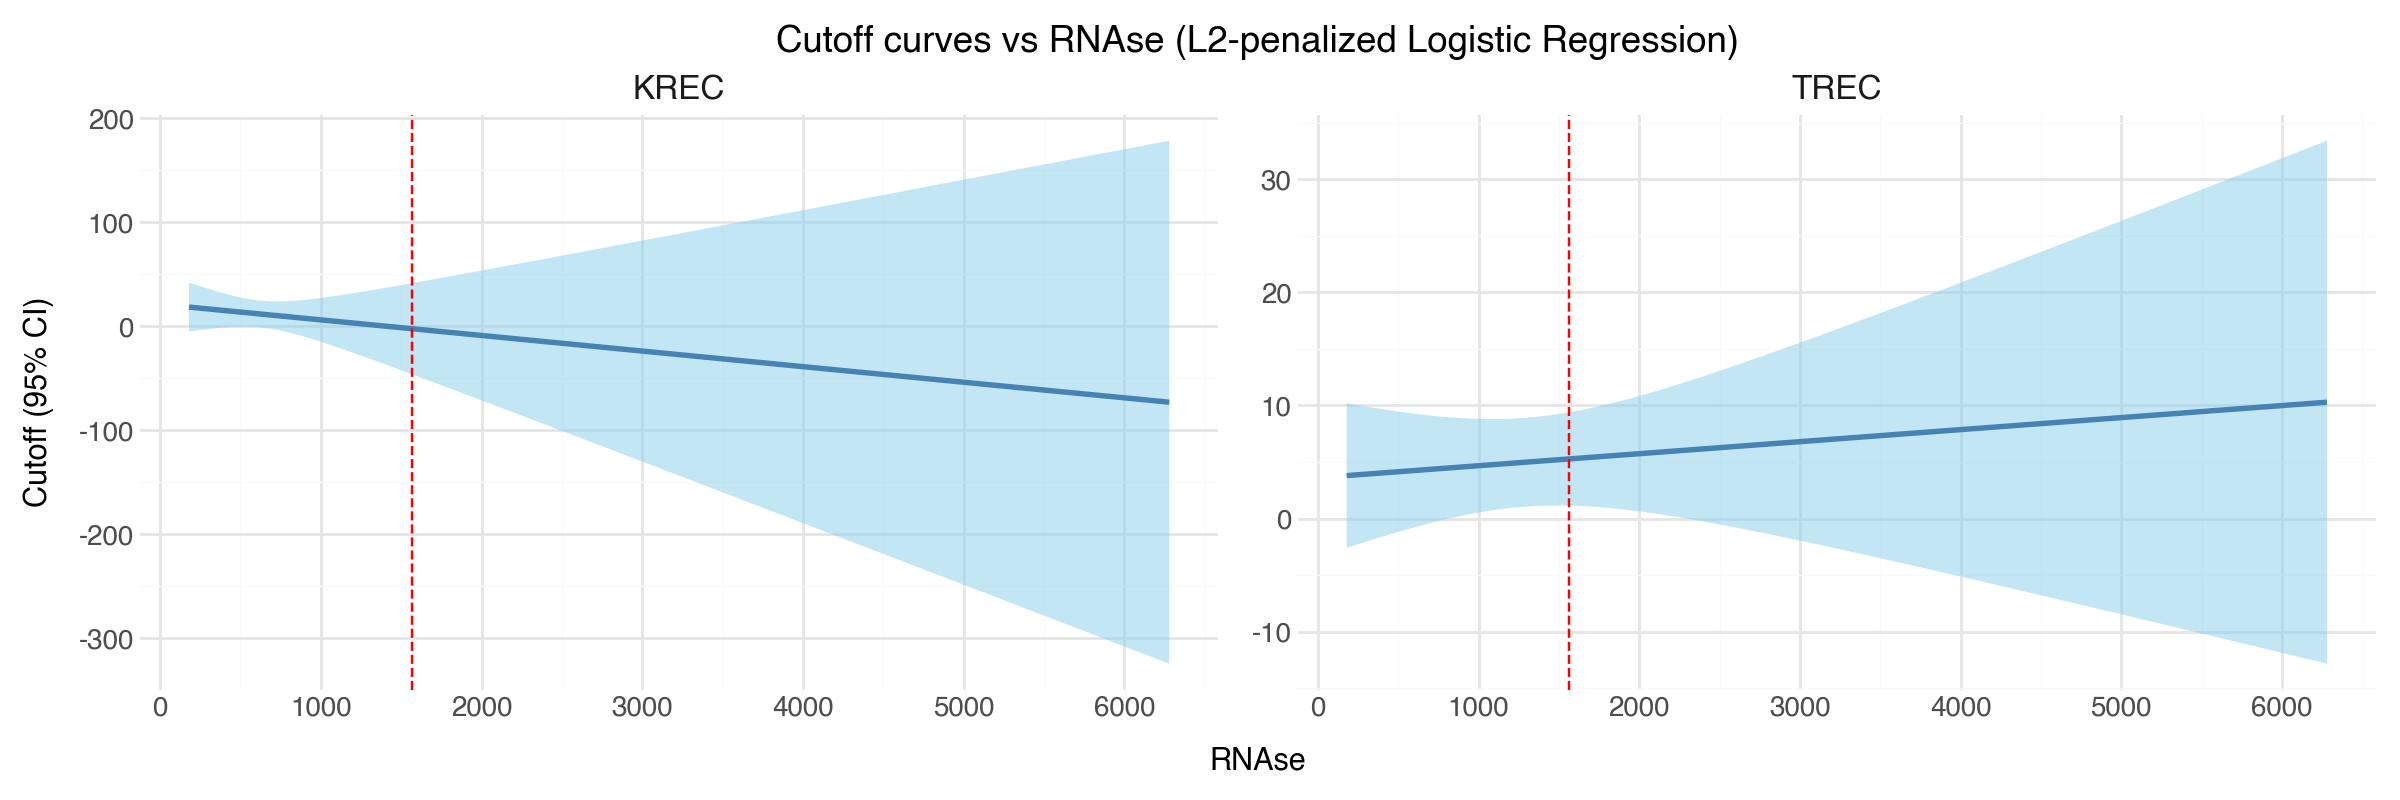

In [15]:
# Combine both cutoff curves
combined_df = pd.concat([df_trec, df_krec], ignore_index=True)
(
    ggplot(combined_df)
    + aes(x="RNAse", y="cutoff")
    + geom_ribbon(aes(ymin="lower", ymax="upper"), fill="skyblue", alpha=0.5)
    + geom_line(size=1.1, color="steelblue")
    + geom_vline(xintercept=RNAse_median, linetype="dashed", color="red")
    + scale_x_continuous(breaks=list(range(0, 6500, 1000)))
    + facet_wrap("~marker", scales="free_y")
    + labs(
        title="Cutoff curves vs RNAse (L2-penalized Logistic Regression)",
        x="RNAse",
        y="Cutoff (95% CI)"
    )
    + theme_minimal()
    + theme(
        axis_title=element_text(size=11), 
        axis_text=element_text(size=10), 
        strip_text=element_text(size=12, weight="bold"),
        figure_size=(12, 4)
    )
)

## Cutoff Derivation Methodology

### Using L2-Penalized (Ridge) Logistic Regression

#### **1. Objective**

The goal of this analysis is to derive a **quantitative cutoff value** for a biological marker (`main_col`, e.g., TREC or KREC) that best classifies a binary outcome (`y_col`, e.g., LT or LB).
Because both the sample size and event frequency are small, the method must:

* Remain **statistically stable** under rare events (class imbalance).
* Provide **interpretable cutoffs** linked to biological variation.
* Incorporate an **inverse covariate** (`inv_col`, e.g., RNAse), which modulates the expected level of the main biomarker.

This ensures that the final cutoff dynamically adjusts for biological context rather than being a fixed value.

#### **2. Model Choice: Ridge (L2) Logistic Regression**

##### **Rationale**

The small dataset (72 samples) and rare outcomes (e.g., only 6 or 2 positives) make a standard logistic regression unstable:

* Maximum-likelihood estimates can diverge (separation problem).
* Coefficients can become inflated or non-identifiable.

To address this, a **ridge-penalized logistic regression** was used.

##### **Why L2 (ridge) instead of L1 or Firth**

* **L2 regularization** shrinks coefficients smoothly toward zero, reducing variance while keeping all predictors active.
* **L1 regularization** (lasso) induces sparsity and can zero out variables — not suitable here since both predictors are biologically relevant.
* **Firth logistic regression**, though ideal for small samples, is not fully supported in modern Python stacks and can be numerically unstable under Python 3.13. The ridge approach approximates its bias reduction behavior with greater stability.

This model minimizes:
$$
L(\beta) = -\sum_i \Big[ y_i \log(p_i) + (1-y_i)\log(1-p_i) \Big] + \lambda \sum_j \beta_j^2
$$
where $\lambda = 10^{-5}$ is a light penalty controlling the degree of shrinkage.

#### **3. Incorporation of the Inverse Covariate**

The `inv_col` (RNAse) enters the model as a **biological adjustment factor**.
Empirically, RNAse levels are inversely correlated with TREC/KREC levels, so higher RNAse is expected to correspond to lower TREC/KREC.

The model structure:
$$
\text{logit}(P(Y=1)) = \beta_0 + \beta_1 Z_{\text{main}} + \beta_2 Z_{\text{inv}}
$$
where $Z_{\text{main}}$ and $Z_{\text{inv}}$ are standardized predictors (mean=0, sd=1).
This standardization improves optimization stability and makes coefficients directly comparable in scale.

#### **4. Optimization Criterion: F₂ Score (Recall-Oriented)**

Given the imbalance (few positive outcomes), **recall** (true positive rate) is prioritized over precision.
The **F₂-score** is used to find the optimal classification threshold:
$$
F_\beta = (1+\beta^2)\frac{\text{Precision} \times \text{Recall}}{(\beta^2 \times \text{Precision}) + \text{Recall}}
$$
with $\beta=2$, meaning recall is weighted **four times** more heavily than precision.

The optimal probability cutoff $p^*$ is chosen as:
$$
p^* = \arg\max_{t \in [0,1]} F_2(t)
$$
This ensures the model emphasizes **sensitivity** — identifying all positive cases is the priority.

#### **5. Translating Probability Cutoff into Marker Cutoff**

After finding the optimal probability threshold $p^*$, the corresponding **cutoff in the main variable** is derived algebraically from the fitted model:
$$
Z_{\text{main,cutoff}} = \frac{\text{logit}(p^*) - \beta_0 - \beta_2 Z_{\text{inv}}}{\beta_1}
$$
Transforming back to the original scale:
$$
\text{Main}*{\text{cutoff}} = \mu*{\text{main}} + \sigma_{\text{main}} \times Z_{\text{main,cutoff}}
$$
This yields a **dynamic cutoff curve** that adapts with RNAse values, capturing biological relationships between markers.

#### **6. Confidence Intervals via the Delta Method**

Uncertainty in the cutoff is approximated using the **delta method**, propagating parameter variance through the transformation above:
$$
Var(\text{Cutoff}) \approx \nabla^\top \Sigma \nabla
$$
where:

* $\Sigma$ = covariance matrix of estimated coefficients,
* $\nabla$ = gradient of the cutoff function w.r.t. parameters.

The **95\% confidence interval** is then:
$$
\text{Cutoff} \pm 1.96 \times SE
$$
This produces the shaded ribbon on the cutoff curve plot.

#### **7. Model Evaluation**

For interpretability, the following metrics are computed using the optimized threshold:

* **Precision (Positive Predictive Value)**
* **Recall (Sensitivity)**
* **F1 and F2 Scores**
* **PR-AUC** (area under the Precision-Recall curve)
* **Confusion Matrix** ([ [TN, FP], [FN, TP] ])

This combination balances **discrimination ability** with interpretability for small, imbalanced samples.

#### **8. Summary**

| Step                   | Purpose                                       | Method                         |
| ---------------------- | --------------------------------------------- | ------------------------------ |
| Model                  | Stable classification under small/rare sample | Ridge (L2) logistic regression |
| Standardization        | Improve numerical stability                   | z-scoring predictors           |
| Inverse covariate      | Account for biological modulation             | RNAse as covariate             |
| Threshold optimization | Favor sensitivity                             | F₂-score maximization          |
| Cutoff derivation      | Translate probability → marker scale          | Algebraic inversion            |
| CI estimation          | Quantify uncertainty                          | Delta method                   |
| Evaluation             | Validate classification quality               | PR-AUC, confusion matrix       |

##### **Advantages of this Method**

* Robust to separation and small samples.
* Produces interpretable, biologically coherent cutoffs.
* Provides uncertainty estimation via confidence bands.
* Emphasizes recall, ideal for diagnostic or screening contexts.